In [ ]:
cat /proc/cpuinfo

Todos
* Recursive Feature Elimination
    * from sklearn.feature_selection import RFE

In [ ]:
client.close()

In [5]:
# Import Dask libraries

from dask import delayed
import joblib
import dask.dataframe as dd
import dask.array as da

from dask.distributed import Client, progress
from sklearn.externals.joblib import parallel_backend

# with joblib.parallel_backend('dask'):

client = Client(processes=False)
client

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Client Scheduler: inproc://10.138.0.6/9999/1 Dashboard: http://10.138.0.6:8787/status,Cluster Workers: 1 Cores: 16 Memory: 109.84 GB


In [1]:
import pandas as pd
import numpy as np


# Tools
from collections import Counter
import pickle

# Features
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from xgboost import plot_importance

# Sampling & Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Model Selection
# from dask_ml.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# # Dask 
# from dask_ml.linear_model import LogisticRegression
# from dask_ml.xgboost import XGBClassifier
# from dask_ml.model_selection import RandomizedSearchCV

# # HyperbandSearchCVis Dask-ML’s meta-estimator to find the best hyperparameters.
# # It can be used as an alternative to RandomizedSearchCV to find similar hyper-parameters
# # in less time by not wasting time on hyper-parameters that are not promising. 
# from dask_ml.model_selection import HyperbandSearchCV 

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Visualizations
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [9]:
# Load dataframe
df = pd.read_pickle('../data/df_clean_2009_2019.pkl')

# # Convert to Dask dataframe
# df = dd.from_pandas(df_pd, npartitions=16)
df.head()

,case_id,target,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,...,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,has_media
151456,11879627,0,2019-12-30 23:20:00,2019-12-31 00:00:00,2019-12-31 00:00:00,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,...,"49 WAYNE PL, SAN FRANCISCO, CA, 94133",WAYNE PL,3.0,Russian Hill,CENTRAL,37.796993,-122.411097,"(37.7969935, -122.4110965)",Web,0
151458,11879619,1,2019-12-30 23:16:00,2019-12-30 23:48:04,2019-12-30 23:48:04,Closed,Case is a Duplicate - This issue has already b...,Parking Enforcement Dispatch Queue,Parking Enforcement,Blocking_Driveway_Cite_Tow,...,"566 HEAD ST, SAN FRANCISCO, CA, 94132",HEAD ST,11.0,Merced Heights,TARAVAL,37.717341,-122.464250,"(37.7173405, -122.4642497)",Web,0
151470,11879549,0,2019-12-30 22:02:44,2019-12-30 23:57:00,2019-12-30 23:57:00,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,...,"30 WAYNE PL, SAN FRANCISCO, CA, 94133",WAYNE PL,3.0,Russian Hill,CENTRAL,37.796814,-122.410926,"(37.7968142, -122.41092551)",Mobile/Open311,1
151471,11879548,0,2019-12-30 22:00:00,2019-12-30 23:19:15,2019-12-30 23:19:15,Closed,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Blocking_Driveway_Cite_Only,...,"1334 JESSIE ST, SAN FRANCISCO, CA, 94103",JESSIE ST,6.0,South of Market,SOUTHERN,37.771108,-122.421109,"(37.771108, -122.4211089)",Mobile/Open311,1
151472,11879547,0,2019-12-30 22:00:00,2019-12-30 23:03:28,2019-12-30 23:03:28,Closed,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Blocking_Driveway_Cite_Only,...,"15 CAINE AVE, SAN FRANCISCO, CA, 94112",CAINE AVE,11.0,Oceanview,TARAVAL,37.717836,-122.449927,"(37.71783559, -122.44992668)",Phone,0


In [ ]:
# Train and test splitting

# Columns to exclude
exclude_cols = [
    'target', # Target variable
    'case_id',
    'opened', # Feature Eng
    'closed', # Feature Eng
    'updated',
    'status',
    'status_notes', # Needs NLP
    'request_details', # Needs NLP
    'address', # Needs NLP
#     'street', # Convert to 'category' type to get dummies
    'point',
    
    # New items
    'responsible_agency',
    'category', # Need to choose 'category' or 'request_type' NOT BOTH
#     'request_type', # Needs NLP
#     'opened_year',
#     'opened_month_sin',
#     'opened_month_cos',
#     'opened_week_sin',
#     'opened_week_cos',
#     'opened_day_sin',
#     'opened_day_cos',
#     'opened_hour_sin',
#     'opened_hour_cos',
    'police_district',
    'supervisor_district',
#     'latitude',
#     'longitude',
]

# # Scale data using MinMax scaler
# # No need to standardize as all features are categorical (maybe scale lat/long....)
# scaler = MinMaxScaler()

# Predictor variables
X = df.drop(columns=exclude_cols, axis=0, inplace=False)

# Get dummies for categorical variables
X = pd.get_dummies(X, drop_first=True)

# Target variable
y = df['target']

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=2020, 
                                                    stratify=y,  # Stratify to keep same class ratios
                                                    shuffle=True # Shuffle data since it's ordered chronologically
                                                   )

X_train.head()

In [ ]:
# # Transform X_train, X_test, y_train, y_test
# X_train = dd.from_pandas(X_train, npartitions=16)
# X_test  = dd.from_pandas(X_test,  npartitions=16)
# y_train = dd.from_pandas(y_train, npartitions=16)
# y_test  = dd.from_pandas(y_test,  npartitions=16)

# Feature Selection

In [ ]:
def select_features(X_train, y_train, X_test):
    '''Returns X_train, X_test, and feature selection function'''
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train)
#     X_train_fs = fs.transform(X_train)
#     X_test_fs = fs.transform(X_test)
#     return X_train_fs, X_test_fs, fs
    return fs

In [ ]:
# Feature selection
# X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
fs = select_features(X_train, y_train, X_test)

In [ ]:
# Feature scores
features_df = pd.DataFrame(data=[X_train.columns, fs.scores_.astype(int)]).transpose()
features_df.rename(columns={0: 'Feature', 1: 'ANOVA F-Value'}, inplace=True)
features_df.sort_values(by='ANOVA F-Value', ascending=False, inplace=True)
features_df.reset_index(drop=True, inplace=True)
features_df

In [ ]:
# Select features above threshold
threshold = 8
best_features_df = features_df[(features_df['ANOVA F-Value'] > threshold)]

In [12]:
# best_features_df.to_pickle('../data/best_features_df.pkl')
best_features_df = pd.read_pickle('../data/best_features_df.pkl')

In [15]:
best_features_df.head()

,Feature,ANOVA F-Value
0,request_type_Abandoned Vehicles,40076
1,request_type_Bulky Items,20830
2,request_type_Abandoned Vehicle - Car4door,8720
3,request_type_Encampment Reports,6768
4,request_type_Parking_on_Sidewalk,4365


In [ ]:
# Filter X_train & X_test with selected features
X_train = X_train.filter(items=best_features_df['Feature'])
X_test  = X_test.filter(items=best_features_df['Feature'])

# Clean column names
X_train.columns = X_train.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '')

X_test.columns = X_test.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '')

In [ ]:
print('df\t', df.shape)
print('X_train\t', X_train.shape)
print('X_test\t', X_test.shape)
print('y_train\t', y_train.shape)
print('y_test\t', y_test.shape)

# Class Balancing

In [11]:
# Target variable
target_count = df['target'].value_counts()

# Print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 3)*100}')

Class 0: 2883435
Class 1: 530199
Proportion: 5.44 : 1
Percentage of Majority Class: 84.5


In [ ]:
# USE DASK from here on out

## Oversampling

In [ ]:
# # A ratio of .5 is saying that 50% of my data is simulated
# # Trevor noted that .2 would be good but let's try different ratios
# smote = SMOTE(random_state=2020)
# X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# # Summarize the new class distribution
# Counter(y_train_smote)

## Undersampling

In [ ]:
# # Define the undersampling method – RandomUnderSampler
rndm_under = RandomUnderSampler(random_state=2020)

# Transform the dataset
X_train_under, y_train_under = rndm_under.fit_sample(X_train, y_train)

# Summarize the new class distribution
Counter(y_train_under)

In [ ]:
# # Define the undersampling method – NearMiss
# # Selects the closest examples from the majority class for each minority class.
# undersample = NearMiss(version=3, n_neighbors_ver3=3)

# # Transform the dataset
# X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# # Summarize the new class distribution
# Counter(y_train_under)

In [2]:
# # Pickle dataframes
# X_train_under.to_pickle('../data/X_train_under.pkl')
# X_test.to_pickle('../data/X_test.pkl')
# y_train_under.to_pickle('../data/y_train_under.pkl')
# y_test.to_pickle('../data/y_test.pkl')

# Load dataframe
X_train_under = pd.read_pickle('../data/X_train_under.pkl')
X_test        = pd.read_pickle('../data/X_test.pkl')
y_train_under = pd.read_pickle('../data/y_train_under.pkl')
y_test        = pd.read_pickle('../data/y_test.pkl')

# # Transform to Dask dataframes
# X_train_under = dd.from_pandas(X_train_under, npartitions=16)
# X_test        = dd.from_pandas(X_test, npartitions=16)
# y_train_under = dd.from_pandas(y_train_under, npartitions=16)
# y_test        = dd.from_pandas(y_test, npartitions=16)

In [ ]:
type(X_train_under)

# Modeling

Objective: Maximize ROC AUC Score as both recall and precision are equally important and the classes are imbalanced

In [ ]:
# Create list of model and performance
model_performance = []
models_optimized = []

User RandomizedSearchCV instead:
https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85


## Baseline Models

In [ ]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy= 'most_frequent').fit(X_train_under, y_train_under)
y_pred = clf.predict(X_test)

#Distribution of y test
print('y actual\t:', Counter(y_test))

#Distribution of y predicted
print('y predicted\t:', Counter(y_pred))

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, y_pred)))

In [ ]:
base_models = []

# Instantiate the models
base_models.append(('LogisticRegression', LogisticRegression(solver='liblinear')))
base_models.append(('KNeighbors', KNeighborsClassifier()))
base_models.append(('RandomForest', RandomForestClassifier(n_estimators=10)))
base_models.append(('XGBoost', XGBClassifier()))

cv_results = []
names = []

# Cross Validate - 5 fold
with joblib.parallel_backend('dask'):
    for name, model in base_models:
        names.append(name)
        cv_results.append(np.round_(cross_val_score(model, X_train_under, y_train_under, cv=5, scoring='roc_auc'), 3))

    for i in range(len(names)):
        print(names[i], round(cv_results[i].mean(), 3))

In [ ]:
# Identify the models that work best without any GridSearchCV
# Plot the ROC Curves
# Undersampling (Don't use synthetic data)
# How to predict duplicates?
## More like unsupervised learning... 
## Create a function – given a point, identify a case that this is more similar to...


In [ ]:
# # Save models
# with open(f'../models/{name}_20k.pkl', 'wb') as f: # how can I save the model for later use?ii
#     pickle.dump(model, f)

## Logistic Regression

In [ ]:
# Grid searching key hyperparameters for logistic regression

# Instantiate model and sampler
lg_model = LogisticRegression()
under = under(random_state=2020)

# Construct pipeline
steps = [('und', under), ('lgr', lg_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'und__random_state': [2020],
    'lgr__solver': ['saga', 'liblinear'],
    'lgr__penalty': ['l1', 'l2'],
    'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# lg_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
lg_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = lg_rndm.fit(X_train_under, y_train_under) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(lg_grid.best_score_)
# print(lg_grid.best_params_)

In [ ]:
# Instantiate model with best paramaters
lg_best = LogisticRegression(C=10, penalty='l2', solver='saga', random_state=2020) # Check the params

# Train with balanced classes
lg_best.fit(X_train_under, y_train_under)

# Get predictions
lg_best_preds = lg_best.predict(X_test)
# lg_best_y_score = lg_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test, lg_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test, lg_best_preds), 3)
precision = round(precision_score(y_test, lg_best_preds), 3)
recall    = round(recall_score(y_test, lg_best_preds), 3)
f1        = round(f1_score(y_test, lg_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, lg_best_preds)))

In [ ]:
# # Add model and accuracy dict to list
# model_performance.append(dict([
#     ('Model', 'Logistic Regression'),
#     ('ROC AUC', round(roc_auc, 3)),
#     ('Precision', round(precision, 3)),
#     ('Recall', round(recall, 3)),
#     ('f1', round(f1_score, 3))
#      ]))

# # Add model to list
# models_optimized.append('Logistic Regression')

## KNN

In [ ]:
# Grid searching key hyperparameters for KNN

# Instantiate model and RandomUnderSampler
knn_model = KNeighborsClassifier()
under = RandomUnderSampler(random_state=2020)

# Construct pipeline
steps = [('und', under), ('knn', knn_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'und__random_state': [2020],
    'knn__n_neighbors' : [3, 5, 7]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# knn_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
knn_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = knn_rndm.fit(X_train_under, y_train_under) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(knn_grid.best_score_)
# print(knn_grid.best_params_)

In [ ]:
# Instantiate model with best paramaters
knn_best = KNeighborsClassifier(n_neighbors=7)

# Train with balanced classes
knn_best.fit(X_train_under, y_train_under)

# Get predictions
knn_best_preds = knn_best.predict(X_test)
# knn_best_y_score = knn_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  knn_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   knn_best_preds), 3)
precision = round(precision_score(y_test, knn_best_preds), 3)
recall    = round(recall_score(y_test,    knn_best_preds), 3)
f1        = round(f1_score(y_test,        knn_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, knn_best_preds)))

In [ ]:
# # Add model and accuracy dict to list
# model_performance.append(dict([
#     ('Model', 'KNN'),
#     ('ROC AUC', round(roc_auc, 3)),
#     ('Precision', round(precision, 3)),
#     ('Recall', round(recall, 3)),
#     ('f1', round(f1_score, 3))
#      ]))

# # Add model to list
# models_optimized.append('KNN')

## Random Forest

In [ ]:
# Grid searching key hyperparameters for Random Forest

# Instantiate model and RandomUnderSampler
rf_model = RandomForestClassifier()
under = RandomUnderSampler(random_state=2020)

# Construct pipeline
steps = [('und', under), ('rfc', rf_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'und__random_state': [2020],
    'rfc__n_estimators': [50, 100, 150, 200, 1000],
    'rfc__max_depth' : [2, 3, 4],
    'rfc__max_features' : [5, 10, 15],
    'rfc__criterion' : ['gini', 'entropy'],
    'rfc__random_state' :[2020]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# rf_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
rf_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = rf_rndm.fit(X_train_under, y_train_under) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(rf_grid.best_score_)
# print(rf_grid.best_params_)

In [ ]:
# Instantiate model with best paramaters
rf_best = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=4, max_features=10, random_state=2020)

# Train with balanced classes
rf_best.fit(X_train_under, y_train_under)

# Get predictions
rf_best_preds = rf_best.predict(X_test)
# rf_best_y_score = rf_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  rf_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   rf_best_preds), 3)
precision = round(precision_score(y_test, rf_best_preds), 3)
recall    = round(recall_score(y_test,    rf_best_preds), 3)
f1        = round(f1_score(y_test,        rf_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, rf_best_preds)))

In [ ]:
# # Add model and accuracy dict to list
# model_performance.append(dict([
#     ('Model', 'Random Forest'),
#     ('ROC AUC', round(roc_auc, 3)),
#     ('Precision', round(precision, 3)),
#     ('Recall', round(recall, 3)),
#     ('F1', round(f1_score, 3))
#      ]))

# # Add model to list
# models_optimized.append('Random Forest')

## XGBoost

In [ ]:
# Grid searching key hyperparameters for XGBoost
# Instantiate model and RandomUnderSampler
xgb_model = XGBClassifier()
under = RandomUnderSampler(random_state=2020)

# Construct pipeline
steps = [('und', under), ('xgb', xgb_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'und__random_state': [2020],
    'xgb__n_estimators': [100, 250, 500, 1000], 
    'xgb__max_depth': [3, 4, 5], 
    'xgb__learning_rate': [0.001, 0.01, 0.1]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# xgb_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
xgb_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='roc_auc')
# # Dask HyperbandSearchCV
# search = HyperbandSearchCV(xgb_model, param_grid, max_iter=3, patience=True)

# Train with balanced classes
grid_result = xgb_rndm.fit(X_train_under, y_train_under)

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')

# # Examine the best model
# print(lg_grid.best_score_)
# print(lg_grid.best_params_)

In [6]:
with joblib.parallel_backend('dask'):


    # Instantiate model with best paramaters
    xgb_best = XGBClassifier(n_estimators=500, max_depth=4, learning_rate=0.1)

    # Train with balanced classes
    xgb_best.fit(X_train_under, y_train_under)

    # Get predictions
    xgb_best_preds = xgb_best.predict(X_test)
    # xgb_best_y_score = xgb_best.predict_proba(X_test)

    # Get ROC AUC Score, precision, recall, f1-score
    accuracy  = round(accuracy_score(y_test,  xgb_best_preds), 3)
    roc_auc   = round(roc_auc_score(y_test,   xgb_best_preds), 3)
    precision = round(precision_score(y_test, xgb_best_preds), 3)
    recall    = round(recall_score(y_test,    xgb_best_preds), 3)
    f1        = round(f1_score(y_test,        xgb_best_preds), 3)

    print(f'Accuracy  : {accuracy}')
    print(f'ROC_AUC   : {roc_auc}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F-score   : {f1}')

    # Confusion matrix
    print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, xgb_best_preds)))

Accuracy  : 0.769
ROC_AUC   : 0.754
Precision : 0.375
Recall    : 0.733
F-score   : 0.496

Confusion Matrix
[[447322 129365]
 [ 28342  77698]]


In [ ]:
# Add model and accuracy dict to list
model_performance.append(dict([
    ('Model', 'XGBoost'),
    ('ROC AUC', round(roc_auc, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3))
     ]))

# Add model to list
models_optimized.append('XGBoost')

# Feature Importance

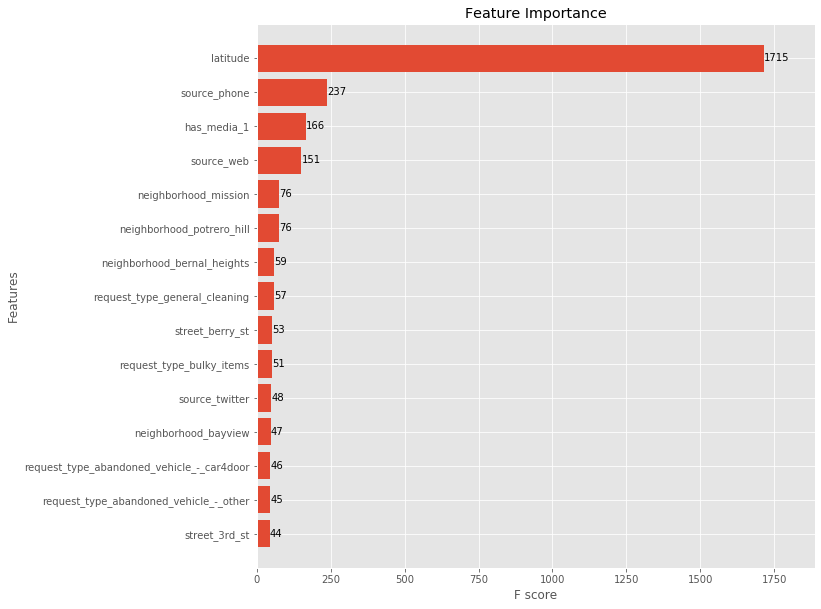

In [7]:
with joblib.parallel_backend('dask'):

    # Feature Importance – XGBoost
    fig, ax = plt.subplots(figsize=(10,10))
    xgb_best.get_booster().feature_names = list(X_test.columns)
    plot_importance(xgb_best.get_booster(), max_num_features=15, height=0.8, ax=ax)
    plt.title('Feature Importance')

    # plt.savefig('feature_importance.png', bbox_inches='tight');

# Model Comparison

In [ ]:
def plot_roc_curves(classifiers, X_train, y_train, X_test, y_test, sampler = None):
    """
        Function for plotting roc curves of classifiers for comparison
        
        :param classifiers: dictionary of classifiers
        :param sampler: sampling method to use e.g. smote
        
        :returns fpr: an array of false positive rate values from roc_curve
        :returns tpr: an array of true positive rate values from roc_curve
        :returns thresholds: an array of threshold values from roc_curve
        :returns roc_auc: roc_auc scores for each classifier in classifiers
        
        https://github.com/kevinchiv/Predicting-Kickstarter-Success/blob/master/02%20-%20Classification%20Modeling.ipynb
    """

    fpr, tpr, thresholds = {}, {}, {}
    roc_auc = {}


    for classifier_name, classifier in classifiers.items():

        #set n_jobs = -1 for faster performance
        classifier = classifier.set_params(n_jobs = -1)

#         if sampler:
#             sampler.set_params(random_state = 42, n_jobs = -1)

        steps = [('sampling', sampler),
                 (classifier_name, classifier)]

        model = Pipeline(steps)

        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:,1]

        fpr[classifier_name], tpr[classifier_name], thresholds[classifier_name] = roc_curve(y_test, y_proba)

        roc_auc[classifier_name] = round(auc(fpr[classifier_name], tpr[classifier_name]), 3)

        print(classifier_name + ' roc_auc score: ' + str(roc_auc[classifier_name]))


    plt.figure(figsize=(8, 8))

    for classifier_name, classifier in classifiers.items():
        sns.lineplot(fpr[classifier_name], tpr[classifier_name], err_style = None);

    midline_points = np.arange(0, 1.05, 0.05) 

    plt.plot(midline_points, midline_points, linestyle ='--', color = 'black');
    plt.title("ROC Curves for Different Classification Models", y =1.05, fontsize = 16);
    plt.xlabel('FPR', fontsize = 12, x = 1.05);
    plt.ylabel('TPR', fontsize = 12, rotation =0, y = 1.05);
    plt.legend(list(zip(classifiers.keys(), roc_auc.values())));

    return fpr, tpr, thresholds, roc_auc

In [ ]:
classifiers = {'KNN': knn_best, 
               'LGR': lg_best, 
               'RFC': rf_best, 
               'XGB': xgb_best,
               'Ensemble': VotingClassifier(estimators=[('lr', lg_best), ('rf', rf_best), ('xgb', xgb_best)],
                                            voting='soft', weights=[1, 1, 1])
              }

fpr, tpr, thresholds, roc_auc = plot_roc_curves(classifiers, X_train_under, y_train_under, X_test, y_test)

## Confusion Matrix for Test Dataset

In [ ]:
# # Print confusion matrix for XGBoost
# xgb_confusion = confusion_matrix(y_test, test_pred_under)

# plt.figure(dpi=125)
# sns.heatmap(xgb_confusion, annot=True, fmt='g', square=True, cbar=False,
#             xticklabels=['no duplicate', 'is duplicate'],
#             yticklabels=['no duplicate', 'is duplicate'])

# plt.title('Confusion Matrix - Test Dataset\nXGBoost', pad=20)
# plt.xlabel('Predicted\n', labelpad=20)
# plt.ylabel('Actual\n', labelpad=20);